In [1]:
import numpy as np
import pandas as pd
import math
import os
from msig import Motif, NullModel
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, MSTL
import matplotlib.pylab as pylab
import matplotlib.dates as mdates

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 20}
pylab.rcParams.update(params)


In [2]:
#read the data
data = pd.read_csv("../data/activityrecognition/S008.csv")
#change timestamp from float to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')
#resample the data to 4 per 1 second
sr = 4
data = data.resample('0.25s').last().ffill()
labels = data['label']
data = data.drop(columns=['label'])
data


back_x    back_y    back_z   thigh_x   thigh_y  \
timestamp                                                                   
2019-01-12 00:00:00.000 -0.830025  0.012523 -0.028120 -0.952283  0.440106   
2019-01-12 00:00:00.250 -1.001197  0.065278 -0.019865 -0.988458 -0.041124   
2019-01-12 00:00:00.500 -1.032066  0.048774 -0.021190 -0.955791  0.082831   
2019-01-12 00:00:00.750 -1.000332  0.056629 -0.018160 -0.955539  0.115507   
2019-01-12 00:00:01.000 -1.016547  0.061868  0.001586 -0.966886  0.109529   
...                           ...       ...       ...       ...       ...   
2019-01-12 02:23:35.500 -1.005256 -0.050133 -0.095170 -0.787561 -0.543610   
2019-01-12 02:23:35.750 -1.054037 -0.158100 -0.093967 -0.947401  0.030492   
2019-01-12 02:23:36.000 -0.983352 -0.131485 -0.125687 -0.989039 -0.054174   
2019-01-12 02:23:36.250 -1.007299 -0.179549 -0.194087 -1.013029 -0.127364   
2019-01-12 02:23:36.500 -0.953996 -0.106440 -0.192335 -1.185141  0.051942   

                          thigh_z  
timestamp                          
2019-01-12 00:00:00.000 -0.227452  
2019-01-12 00:00:00.250 -0.258311  
2019-01-12 00:00:00.500 -0.275174  
2019-01-12 00:00:00.750 -0.251909  
2019-01-12 00:00:01.000 -0.251787  
...                           ...  
2019-01-12 02:23:35.500 -0.198609  
2019-01-12 02:23:35.750 -0.225650  
2019-01-12 02:23:36.000 -0.039868  
2019-01-12 02:23:36.250 -0.097164  
2019-01-12 02:23:36.500 -0.149504  

[34467 rows x 6 columns]

In [3]:
results_path = "../results/activityrecognition/"+str(sr)
#create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path+"/mp")
    os.makedirs(results_path+"/mp_indices")

In [4]:
#resid
stats_table = pd.DataFrame()
resids = {}

#get the data for those features
for data_feature in data.columns:
    print(data_feature)
    time_serie = data[data_feature]
    #5hz, 1 second is 5 samples, 1 minute is 300 samples, 1 hour is 18000 samples
    res = MSTL(time_serie, periods=[int(sr*60),int(sr*60*60)]).fit() #seasonal period is 1 minute, 1 hour
    resids[data_feature] = res.resid

    var_resid = np.var(res.resid)
    var_observed = np.var(res.observed)
    trend_strength = max(0, 1 - (var_resid/np.var(res.trend+res.resid)))
    noise_strength = var_resid/var_observed

    seasonal_individial_strengths = {}
    for period in res.seasonal:
        seasonal_individial_strengths["F_"+str(period)] = max(0, 1 - (var_resid/np.var(res.seasonal[period] + res.resid)))
    seasonal_strength = max(0, 1 - (var_resid/np.var(res.seasonal.sum(axis=1) + res.resid)))

    stats_df = {"Feature": data_feature,
                "F_T": round(trend_strength, 3),
                "F_S": round(seasonal_strength, 3), "F_R": round(noise_strength, 3)}
        
    #add individual seasonal strengths to stats_df, rounded with 3 decimals
    for period in seasonal_individial_strengths:
        stats_df[period] = round(seasonal_individial_strengths[period], 3)
            
    stats_table = pd.concat([stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True)

pd.DataFrame(resids).to_csv(results_path+"/resids.csv", index=True)
stats_table

back_x
back_y
back_z
thigh_x
thigh_y
thigh_z


Feature    F_T    F_S    F_R  F_seasonal_240  F_seasonal_14400
0   back_x  0.215  0.859  0.138           0.271             0.847
1   back_y  0.439  0.799  0.188           0.297             0.772
2   back_z  0.511  0.824  0.161           0.116             0.818
3  thigh_x  0.539  0.904  0.091           0.192             0.901
4  thigh_y  0.352  0.816  0.167           0.296             0.793
5  thigh_z  0.530  0.857  0.126           0.156             0.851

In [5]:
#motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2 # r = np.ceil(m/2)
include = None
normalize = False
subsequence_lengths = [sr*30, sr*60, sr*60*5] # 30s, 1m, 5m 

In [6]:
resids = pd.read_csv(results_path+"/resids.csv", index_col=0).T
resids

timestamp  2019-01-12 00:00:00.000  2019-01-12 00:00:00.250  \
back_x                    0.022782                -0.007267   
back_y                    0.010492                 0.030649   
back_z                    0.096220                 0.090665   
thigh_x                  -0.222430                -0.209239   
thigh_y                  -0.052941                -0.147942   
thigh_z                  -0.227696                -0.229929   

timestamp  2019-01-12 00:00:00.500  2019-01-12 00:00:00.750  \
back_x                   -0.007171                 0.034545   
back_y                    0.028305                 0.069038   
back_z                    0.102349                 0.055027   
thigh_x                  -0.231486                -0.180111   
thigh_y                  -0.102892                -0.157406   
thigh_z                  -0.232626                -0.182344   

timestamp  2019-01-12 00:00:01.000  2019-01-12 00:00:01.250  \
back_x                   -0.014355                -0.010634   
back_y                    0.050589                 0.039118   
back_z                    0.100108                 0.095036   
thigh_x                  -0.217721                -0.230031   
thigh_y                  -0.110786                -0.108668   
thigh_z                  -0.234870                -0.223439   

timestamp  2019-01-12 00:00:01.500  2019-01-12 00:00:01.750  \
back_x                   -0.012319                -0.015238   
back_y                    0.038812                 0.039746   
back_z                    0.100282                 0.097886   
thigh_x                  -0.225557                -0.218976   
thigh_y                  -0.120270                -0.115399   
thigh_z                  -0.234427                -0.237412   

timestamp  2019-01-12 00:00:02.000  2019-01-12 00:00:02.250  ...  \
back_x                   -0.009949                -0.007990  ...   
back_y                    0.025881                 0.031598  ...   
back_z                    0.103628                 0.097083  ...   
thigh_x                  -0.219476                -0.221779  ...   
thigh_y                  -0.118606                -0.121771  ...   
thigh_z                  -0.237959                -0.242296  ...   

timestamp  2019-01-12 02:23:34.250  2019-01-12 02:23:34.500  \
back_x                   -0.000887                 0.018216   
back_y                   -0.067729                -0.093495   
back_z                    0.139218                 0.147814   
thigh_x                  -0.070604                -0.108511   
thigh_y                   0.026521                 0.025569   
thigh_z                  -0.032345                -0.020988   

timestamp  2019-01-12 02:23:34.750  2019-01-12 02:23:35.000  \
back_x                   -0.019784                -0.010189   
back_y                   -0.076923                -0.081456   
back_z                    0.155298                 0.148547   
thigh_x                  -0.075683                -0.067479   
thigh_y                   0.026080                 0.021866   
thigh_z                  -0.063001                -0.040805   

timestamp  2019-01-12 02:23:35.250  2019-01-12 02:23:35.500  \
back_x                   -0.021730                -0.022449   
back_y                   -0.058264                -0.001643   
back_z                    0.129012                 0.091992   
thigh_x                  -0.110463                -0.025202   
thigh_y                   0.036804                 0.006651   
thigh_z                  -0.015304                 0.043473   

timestamp  2019-01-12 02:23:35.750  2019-01-12 02:23:36.000  \
back_x                   -0.028030                -0.019019   
back_y                   -0.045410                -0.050663   
back_z                    0.098153                 0.091215   
thigh_x                  -0.117791                -0.121338   
thigh_y                   0.046386                 0.025992   
thigh_z                  -0.051431                -

In [7]:
for m in subsequence_lengths:
    mp, mp_indices = stumpy.mstump(resids.values, m, normalize=normalize)
    np.save(results_path+'/mp/normalized={}_m={}_multivariate.npy'.format(normalize,m), mp, allow_pickle=True)
    np.save(results_path+'/mp_indices/normalized={}_m={}_multivariate.npy'.format(normalize,m), mp_indices, allow_pickle=True)

In [8]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))

def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) <= m/2:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time-m)/np.ceil(m/2)+1))

        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]

        #minmax normalize subsequence
        epsilon = 1e-10 # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (max_values - min_values + epsilon)
        ce_norm_subsequence = multivar_subsequence_complexity(normalized_multivar_subsequence)
        norm_ce_norm_subsequence = ce_norm_subsequence/(np.sqrt(len(multivar_subsequence[0])-1)*len(dimensions))

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = max(np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)]), epsilon)
        
        unified_weights = "0.33,0.33,0.33"
        excl_zone = np.ceil(m/4)
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = w1*(1-(med_dist/max_allowed_dist)) + w2*(len(match_indices)/max_possible_matches) + w3*norm_ce_norm_subsequence

        #remove timepoints from time series in match all indices + m
        time_series_nomatches = data[dimension].copy()
        #list of indexes to remove
        indexes_to_remove = [i for index in match_indices for i in range(index, index + m)]
        #put zero in the indexes to remove
        time_series_nomatches[indexes_to_remove] = 0

        #calculate variance explained by the motif
        variance_explained = 100 * (1 - (np.var(time_series_nomatches) / np.var(data[dimension])))

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        #max_delta = max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m) 
        delta_thresholds = [max_delta]*len(data)
        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(max_possible_matches, n_vars, idd_correction=False) 

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "CE": np.around(norm_ce_norm_subsequence,3), "Score Unified": np.around(unified,3),
                        "Explained Var(%)": np.around(variance_explained,2),
                        "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.DataFrame.from_records([stats_df]) if mp_stats_table.empty else pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [9]:
min_neighbors = 2
max_distance = None
max_matches = 99999
max_motifs = 99999
cutoff = np.inf
k = None
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    X = resids.values
    mp = np.load(results_path+'/mp/normalized={}_m={}_multivariate.npy'.format(normalize, m), allow_pickle=True)
    mp_indices = np.load(results_path+'/mp_indices/normalized={}_m={}_multivariate.npy'.format(normalize, m), allow_pickle=True)

    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(X, mp, mp_indices, min_neighbors=min_neighbors, max_distance=max_distance,
                                                                    cutoffs=np.inf, max_matches=max_matches, max_motifs=max_motifs, k=k, include=include, normalize=normalize)  
    
    if len(motif_indices[0]) == 0:
        continue
    print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
    table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance)
    print("Sig ", np.sum(table["p-value"] < 0.01))
    #hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
    sig = table["p-value"] < critical_value if critical_value != 0 else table["p-value"] <= critical_value
    table["Sig_Hochber"] = sig

    print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))
    mp_stats_table = table if mp_stats_table.empty else pd.concat([mp_stats_table, table], ignore_index=True)

    mp_stats_table.to_csv(results_path+'/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs), index=False)

[120, 240, 1200]
(6, 34467)
(6, 34348)
m:120, #Motifs:14
Sig  14
Sig after Hochberg: 14, critical value: 0.0
(6, 34467)
(6, 34228)
m:240, #Motifs:6


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:76: RuntimeWarning: overflow encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Sig  6
Sig after Hochberg: 6, critical value: 0.0
(6, 34467)
(6, 33268)


In [10]:
#create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std, 
#average probability +- std, average pvalue +- std)

mp_stats_table = pd.read_csv(results_path+'/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs))
motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(columns=["m", "#motifs" , "avg_n_matches", "avg_n_features",  "avg_probability",  "avg_pvalue", "#sig_motifs(<0.01)", "significant", "#sig_hochberg"])
for m in subsequence_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    if table.empty:
        continue
    n_motifs = table.shape[0]
    n_sig_motifs_001 = table[table["p-value"] < 0.01].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
    avg_n_matches = round(table["#Matches"].mean(),2), round(table["#Matches"].std(),3)
    avg_n_features = round(table["k"].mean(),2), round(table["k"].std(),3)
    avg_probability = table["P"].mean(), table["P"].std()    
    avg_pvalue = table["p-value"].mean(), table["p-value"].std()

    stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.01)": n_sig_motifs_001, "significant":(n_sig_motifs_001*100)/n_motifs,
                "avg_n_matches": avg_n_matches}
    
    motif_stats_table = pd.DataFrame.from_records([stats_df]) if motif_stats_table.empty else pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
print(motif_stats_table.to_latex(index=False))


\begin{tabular}{rrrrl}
\toprule
m & #motifs & #sig_motifs(<0.01) & significant & avg_n_matches \\
\midrule
120 & 14 & 14 & 100.000000 & (6.57, 3.081) \\
240 & 6 & 6 & 100.000000 & (3.67, 1.366) \\
\bottomrule
\end{tabular}



In [11]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        #label x with i+index
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)

        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig(results_path+'/m='+str(m)+'_motif_'+str(motif_name)+".pdf",bbox_inches='tight')
  
    return None

Motif length:  120
Motif length:  240


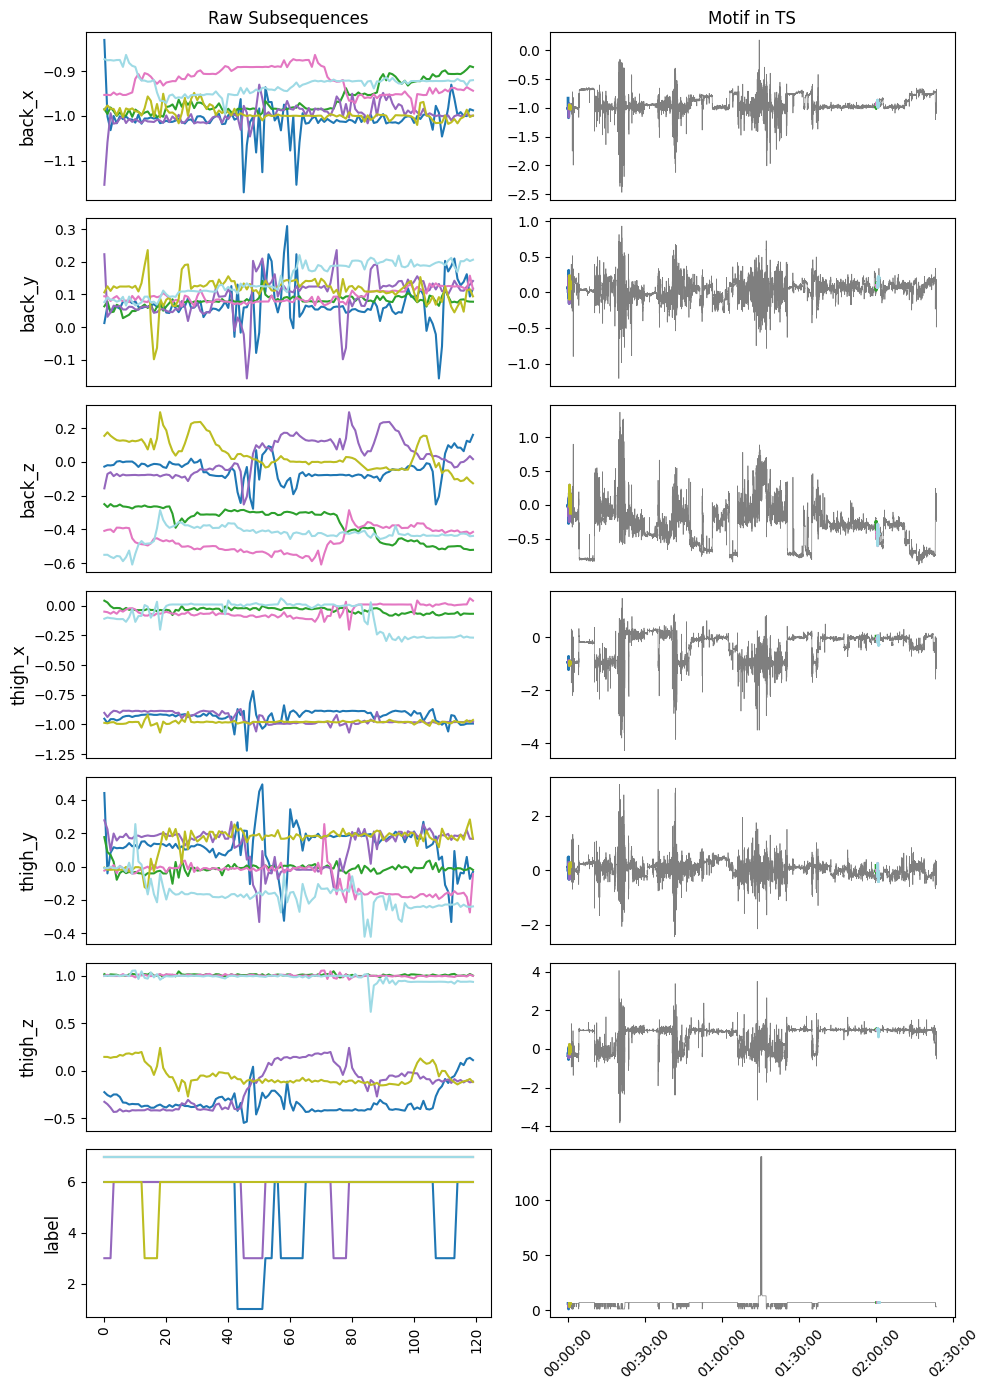

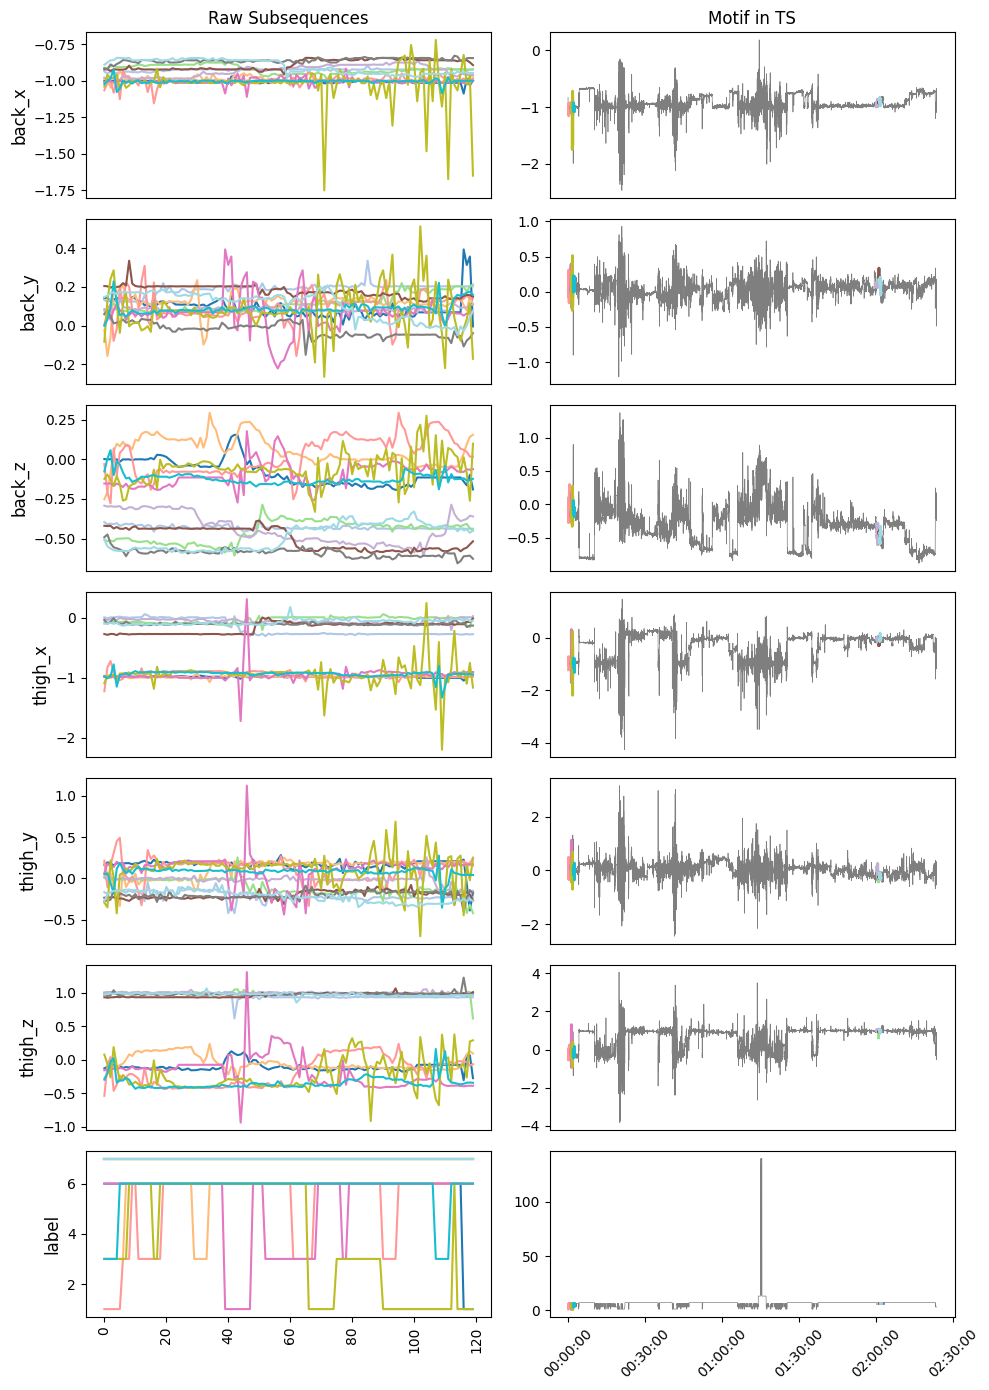

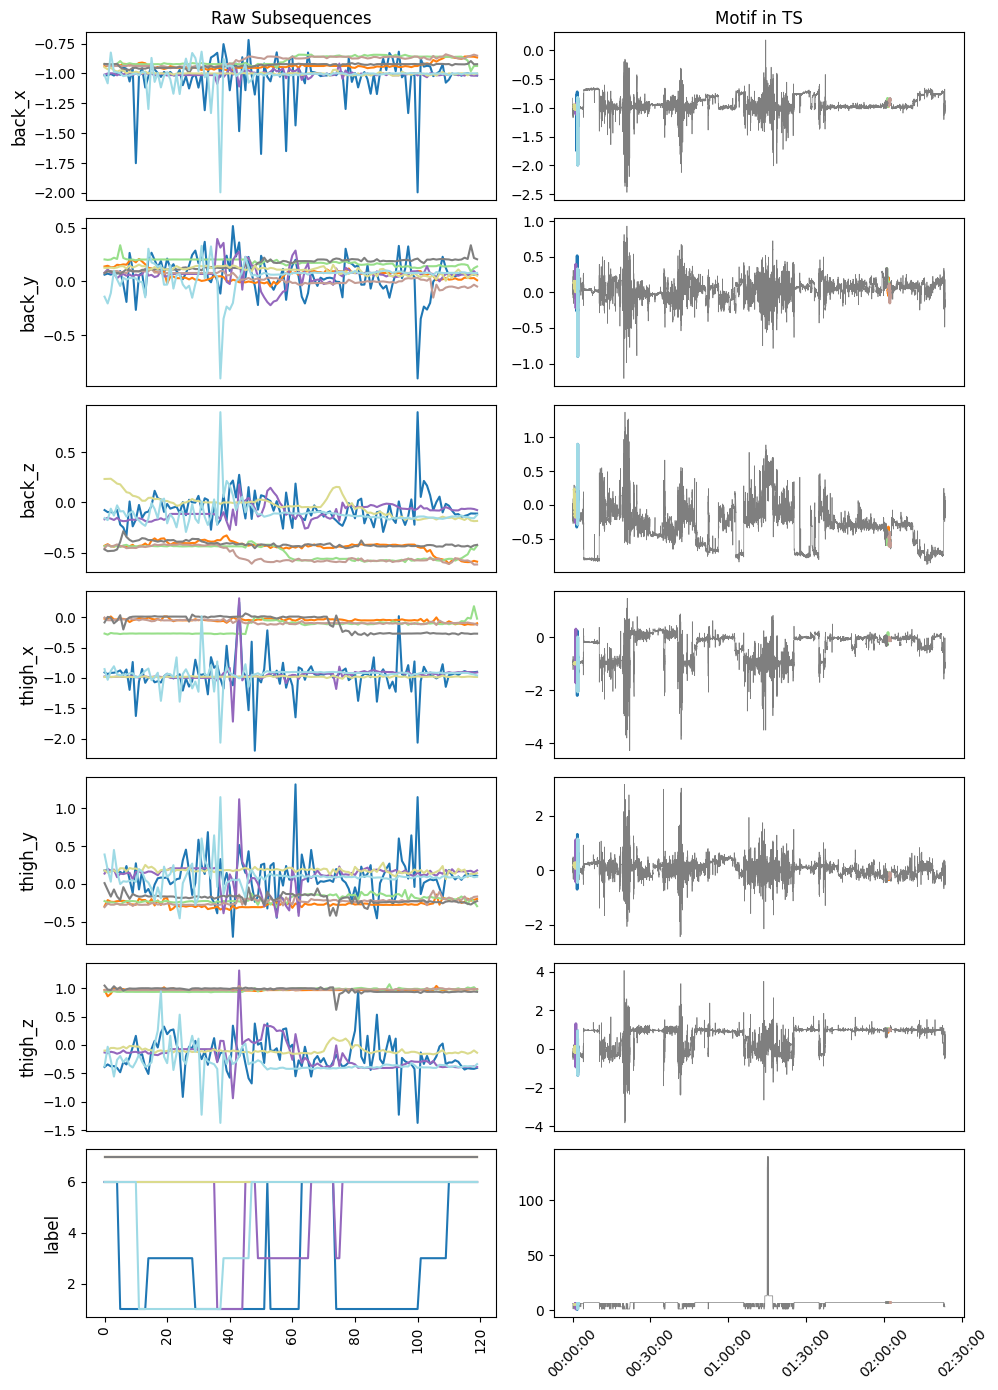

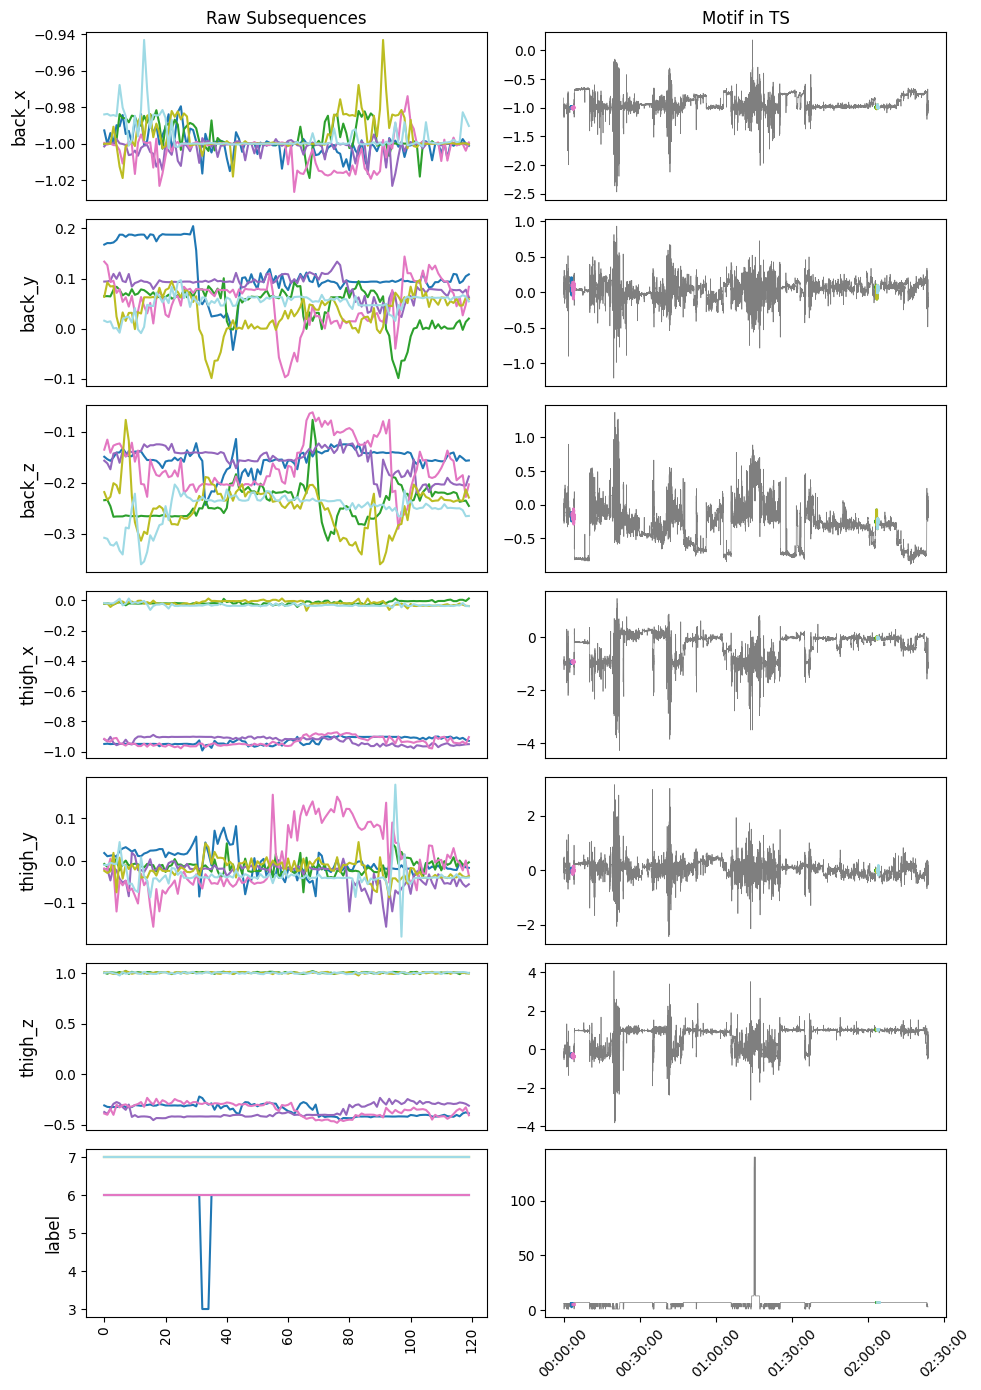

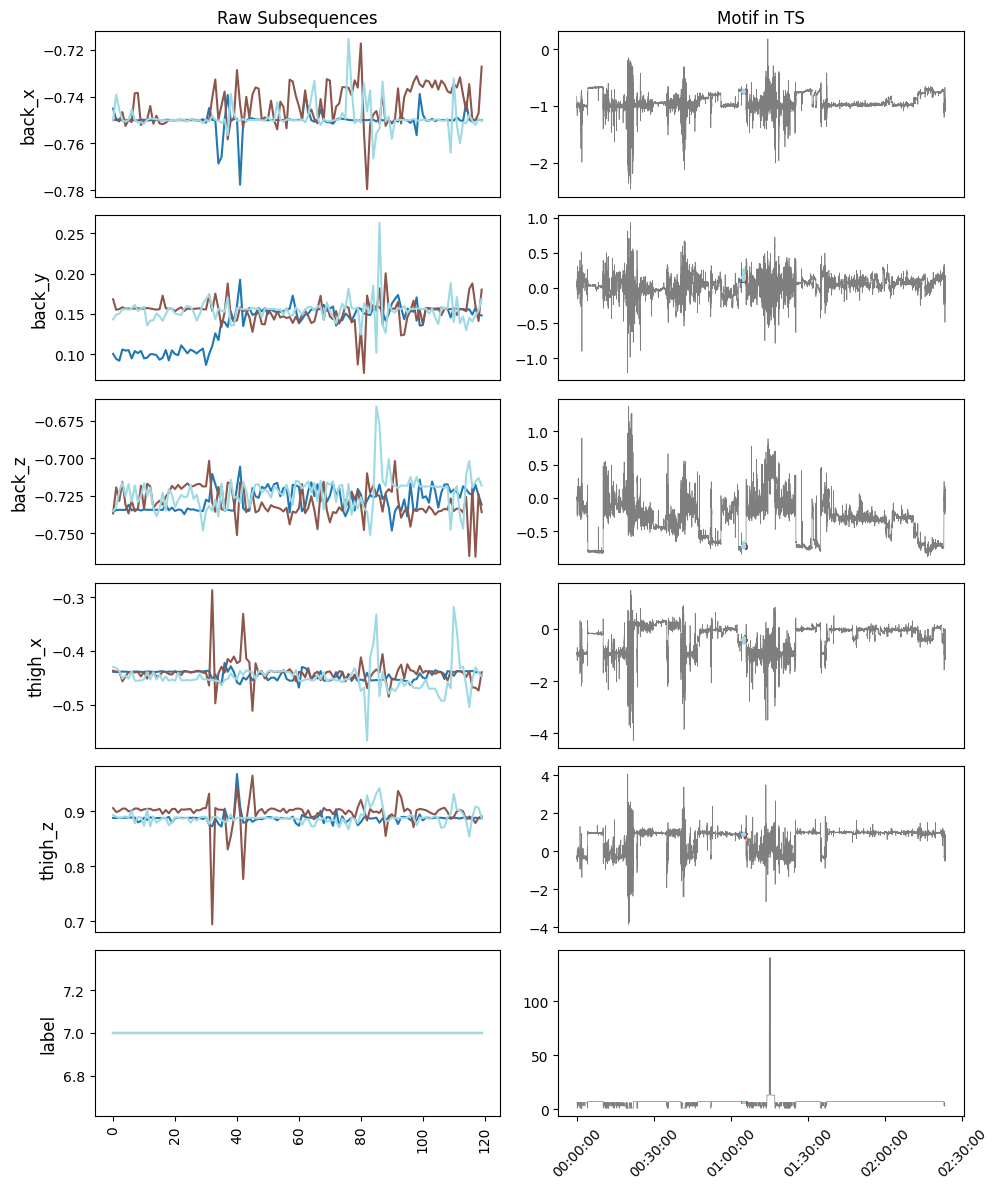

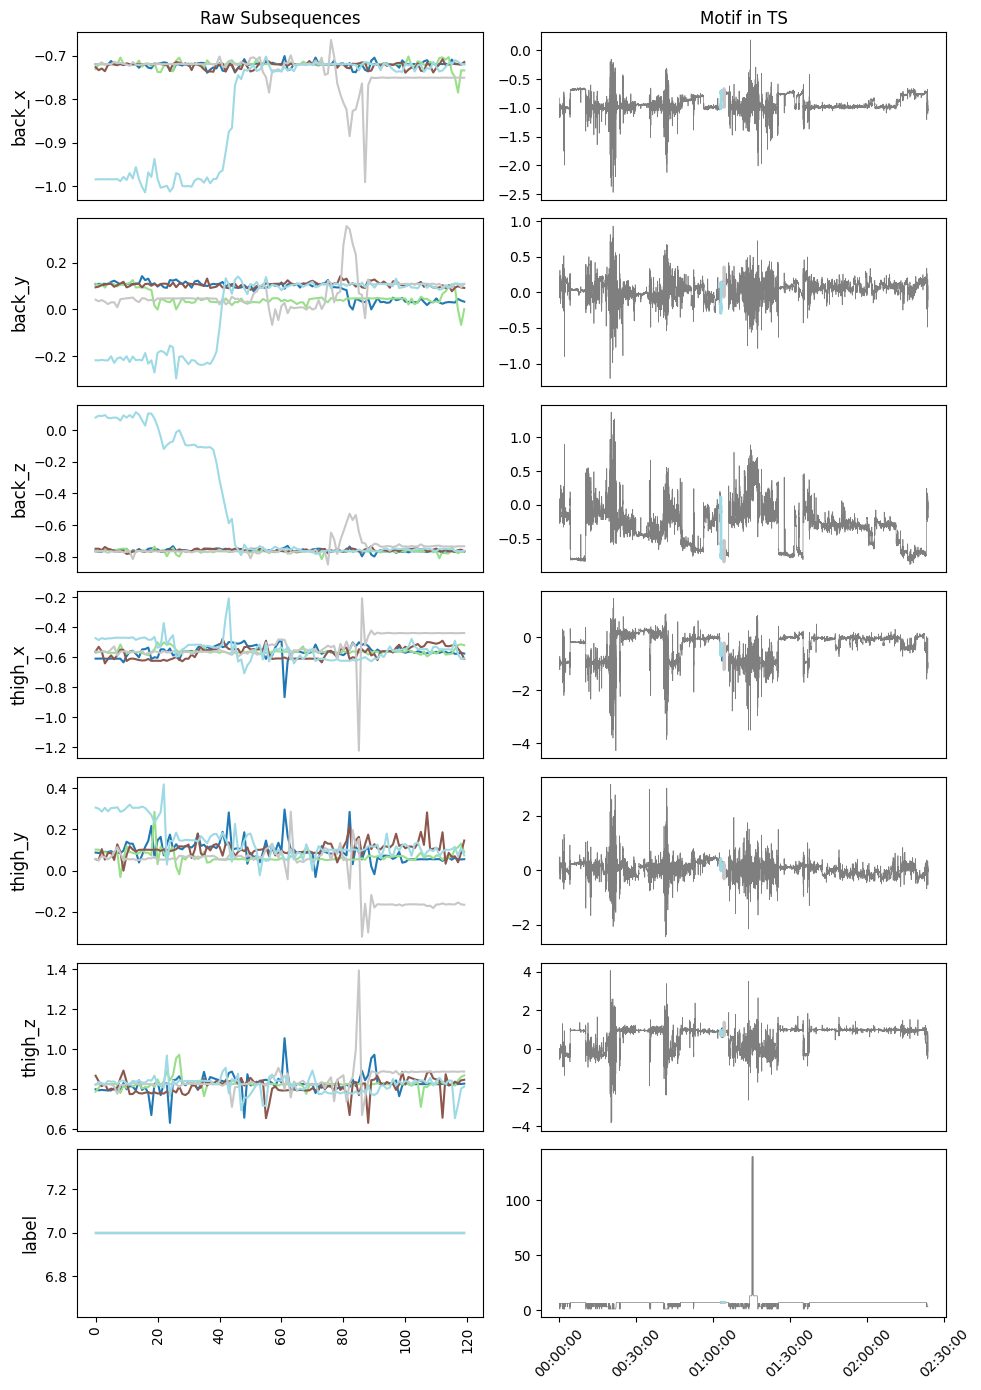

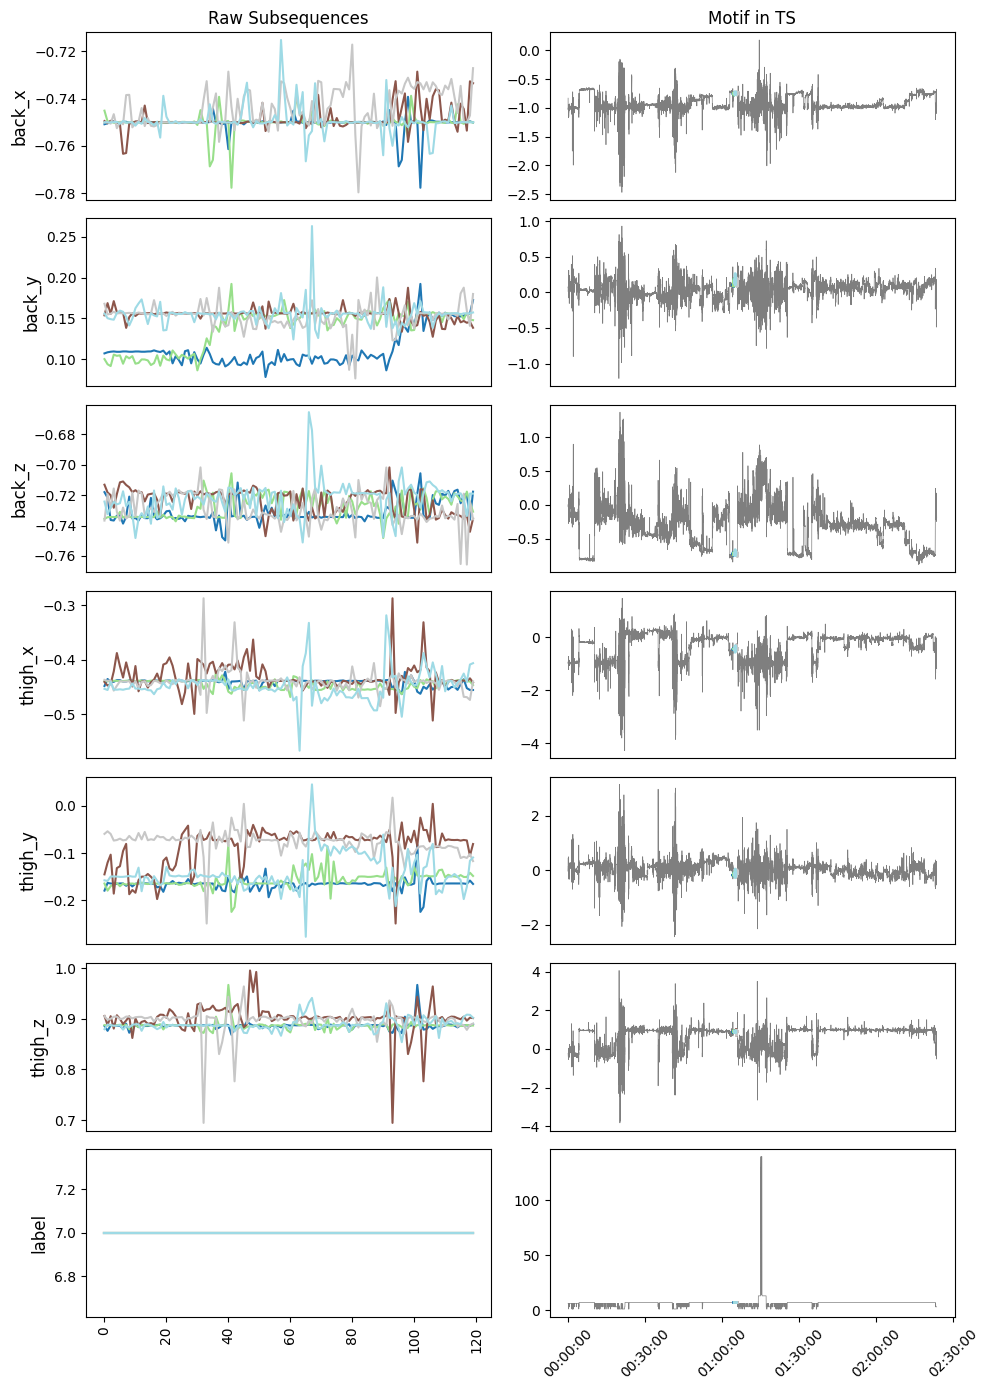

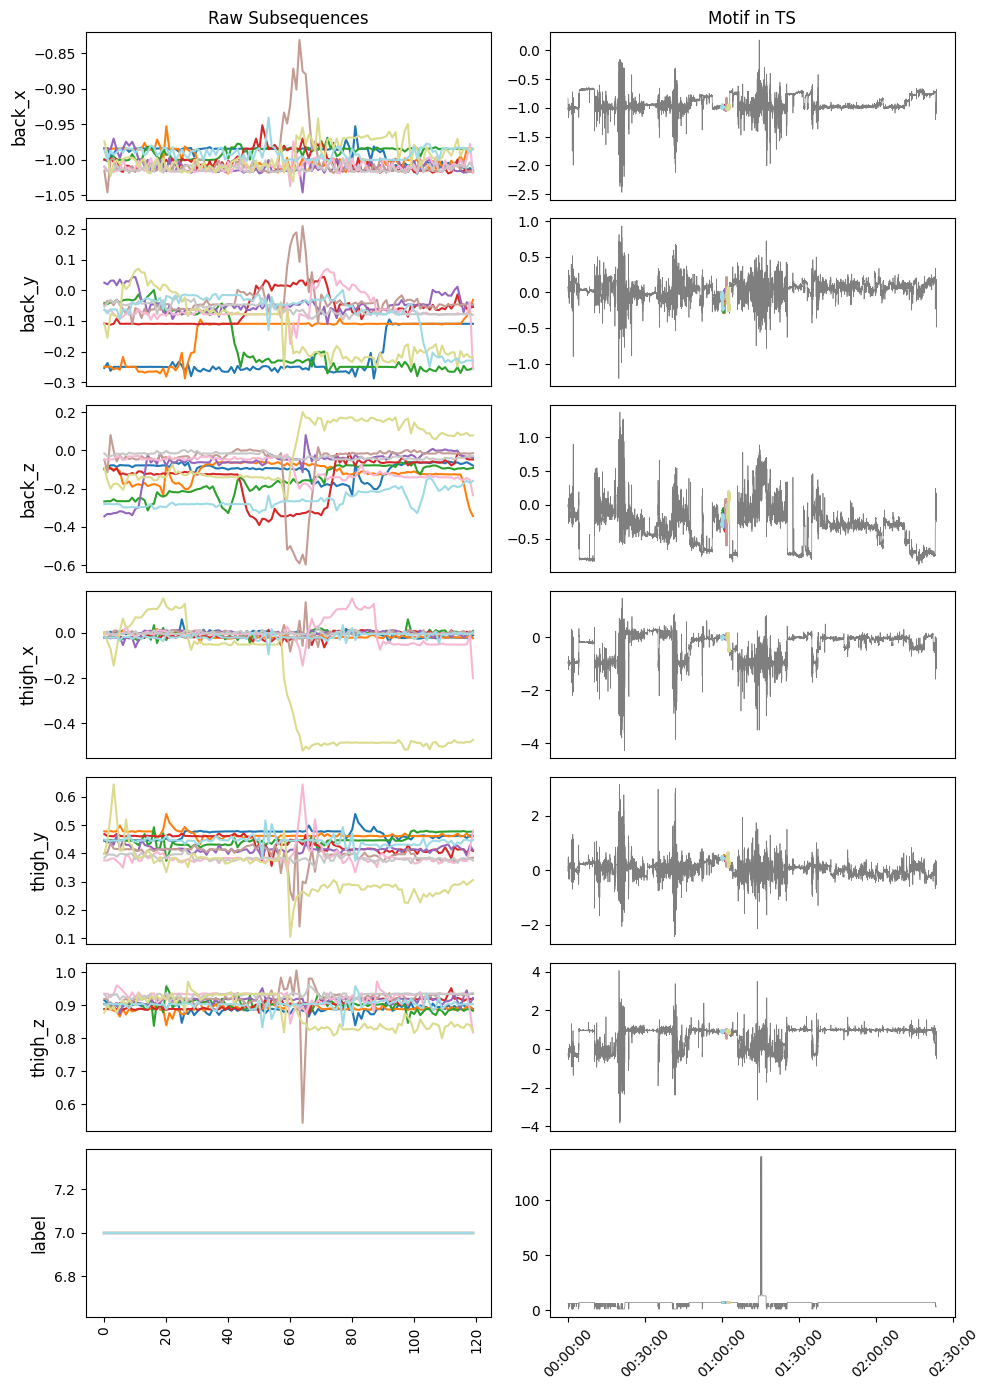

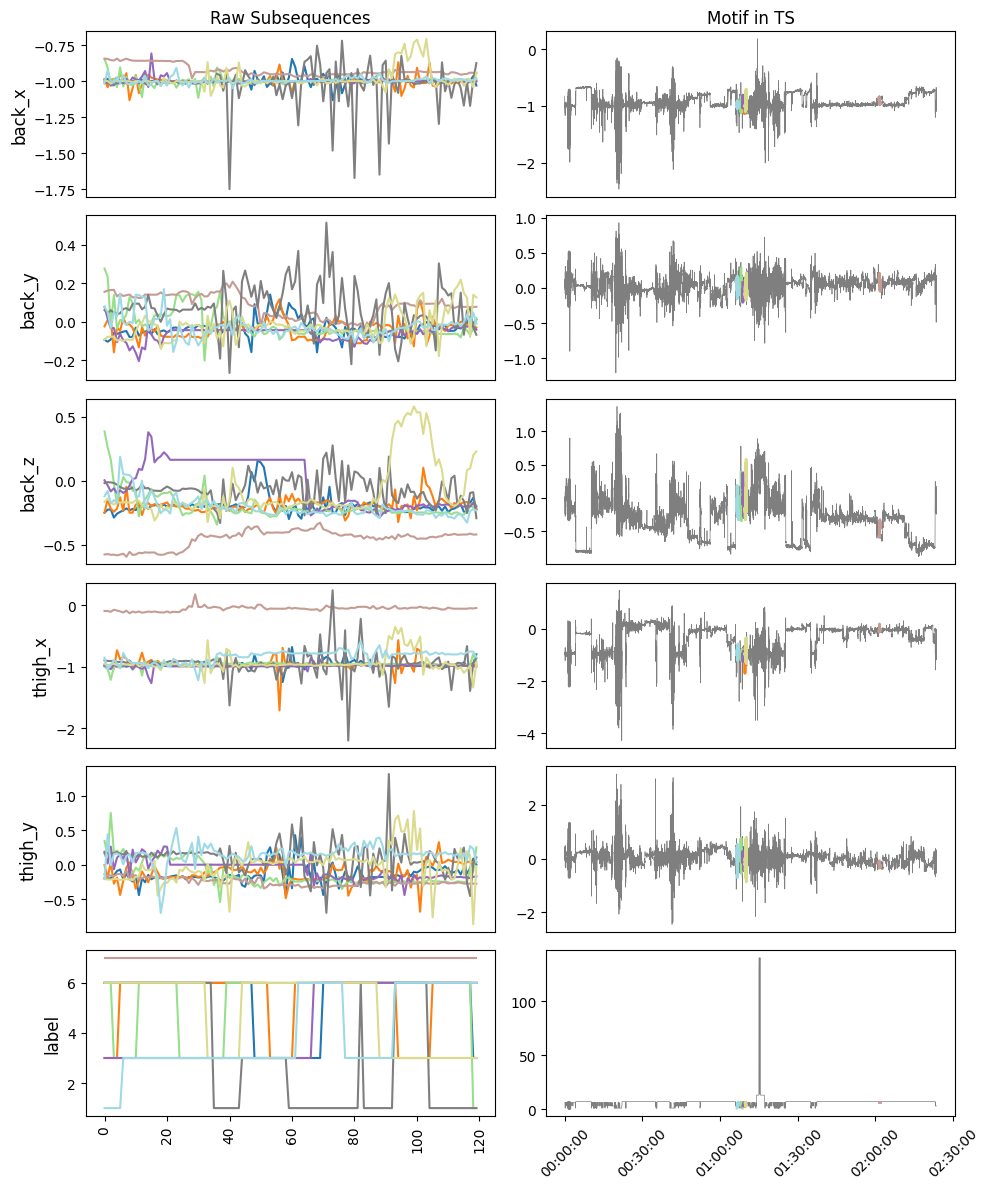

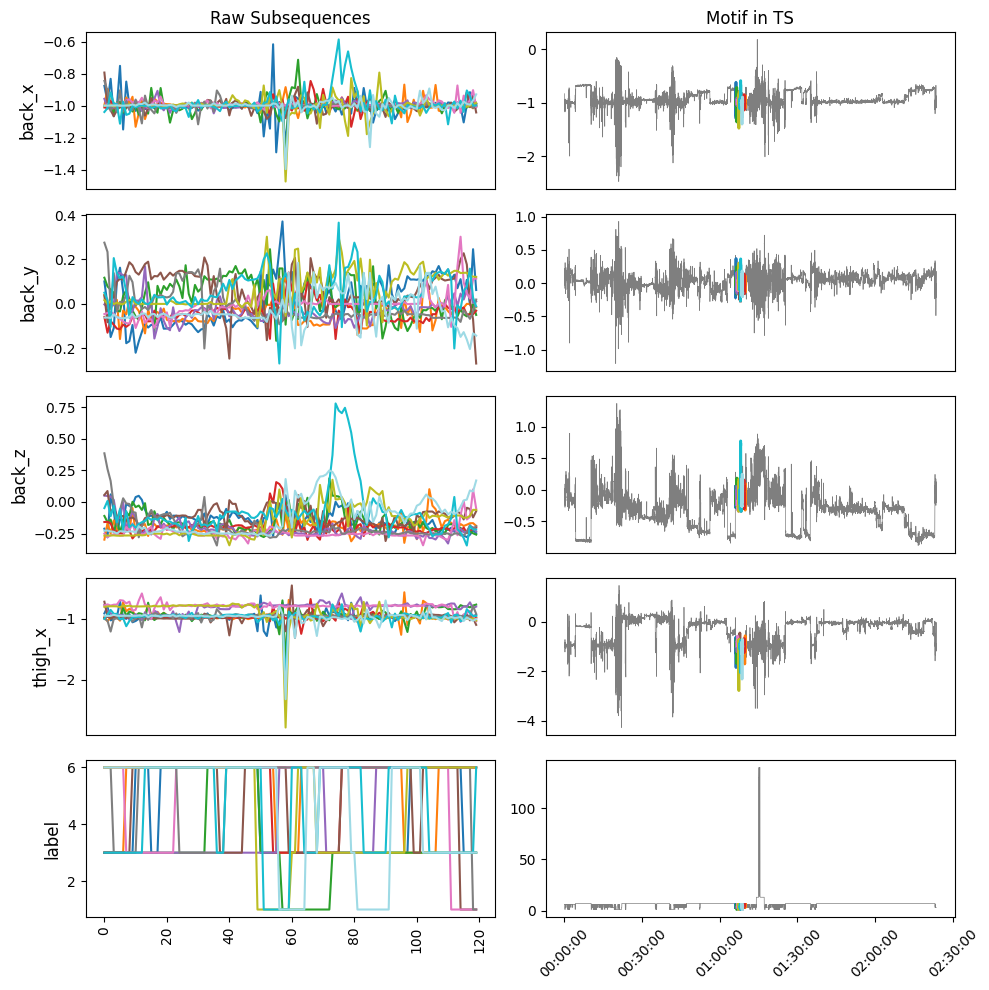

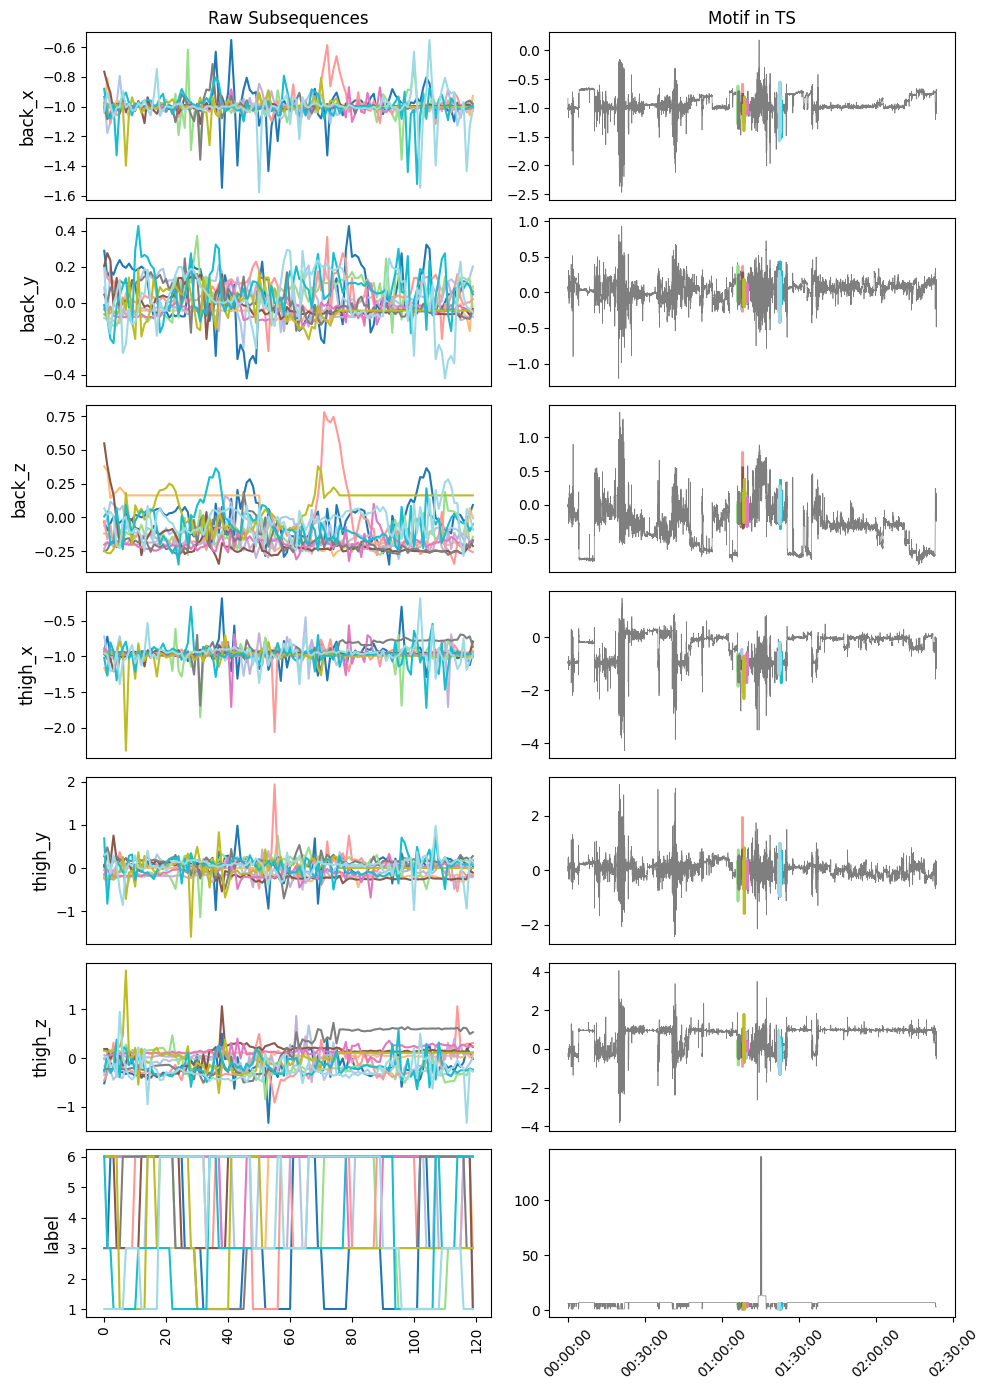

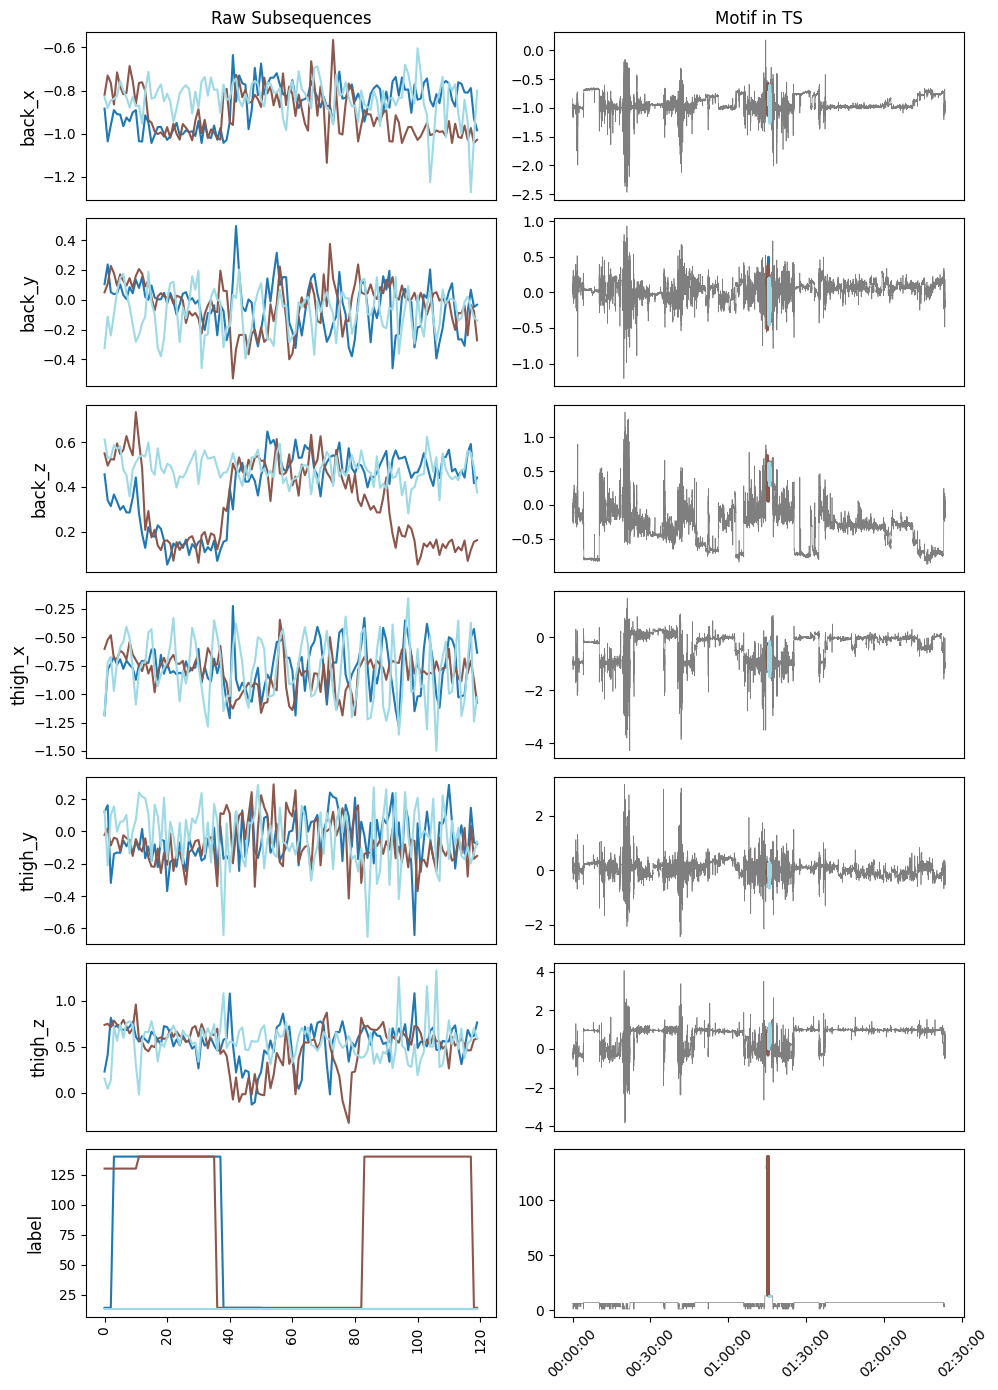

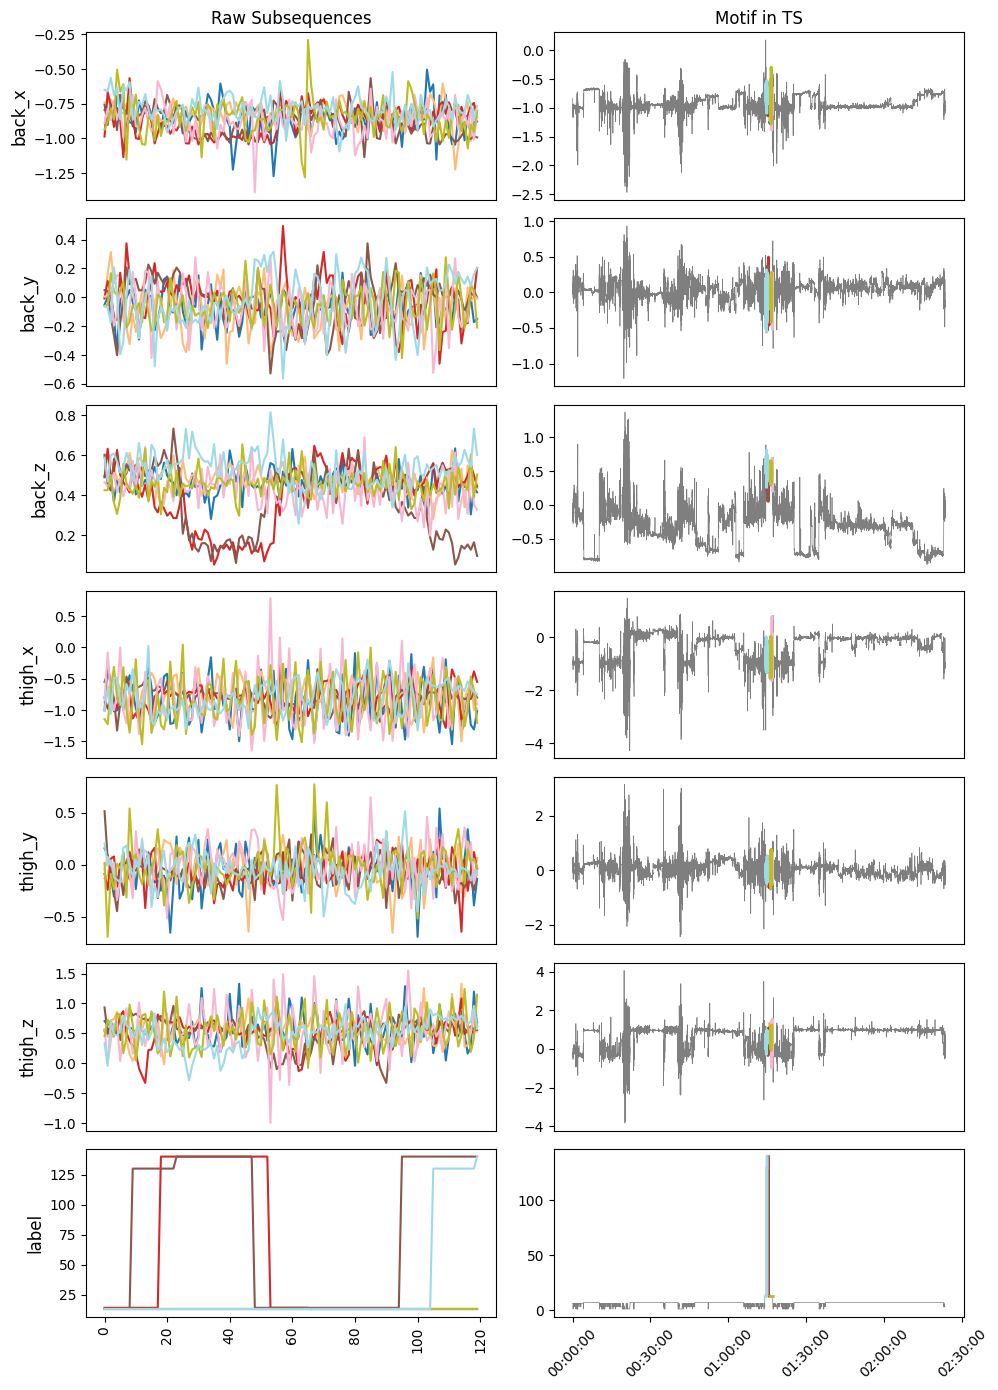

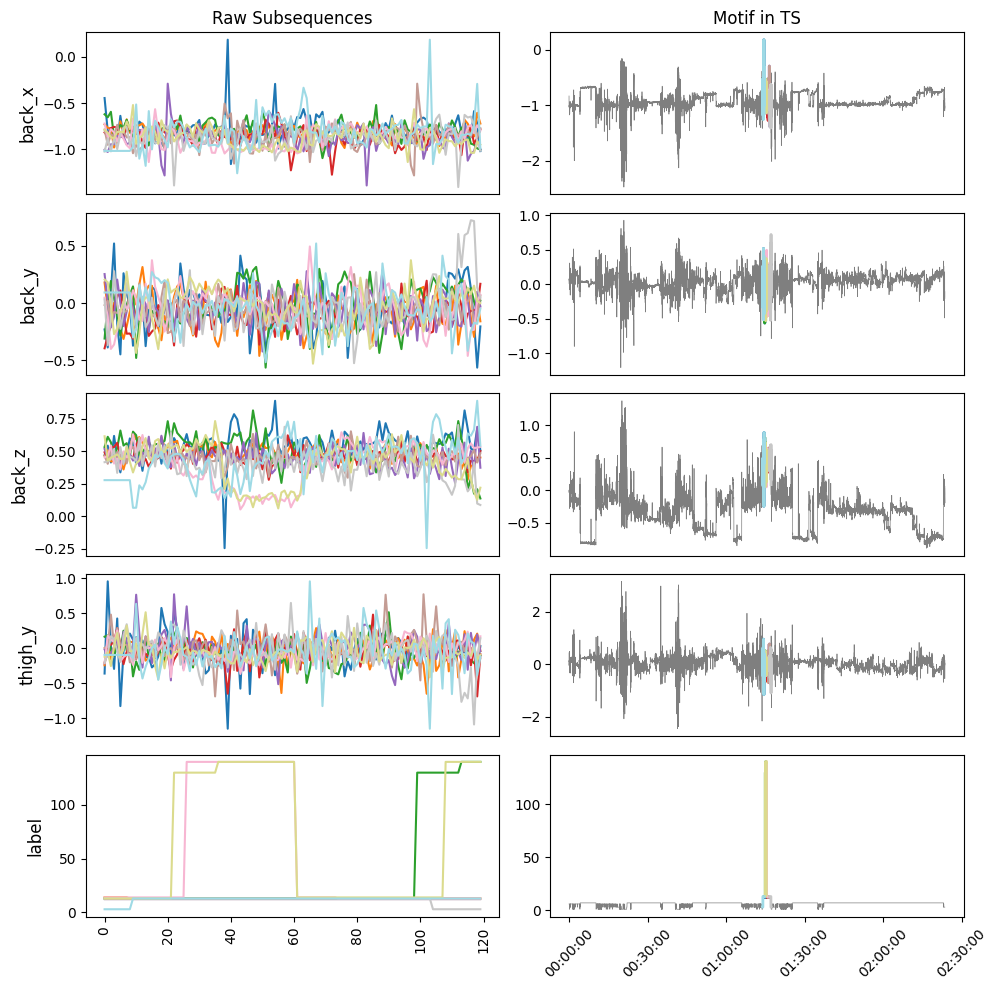

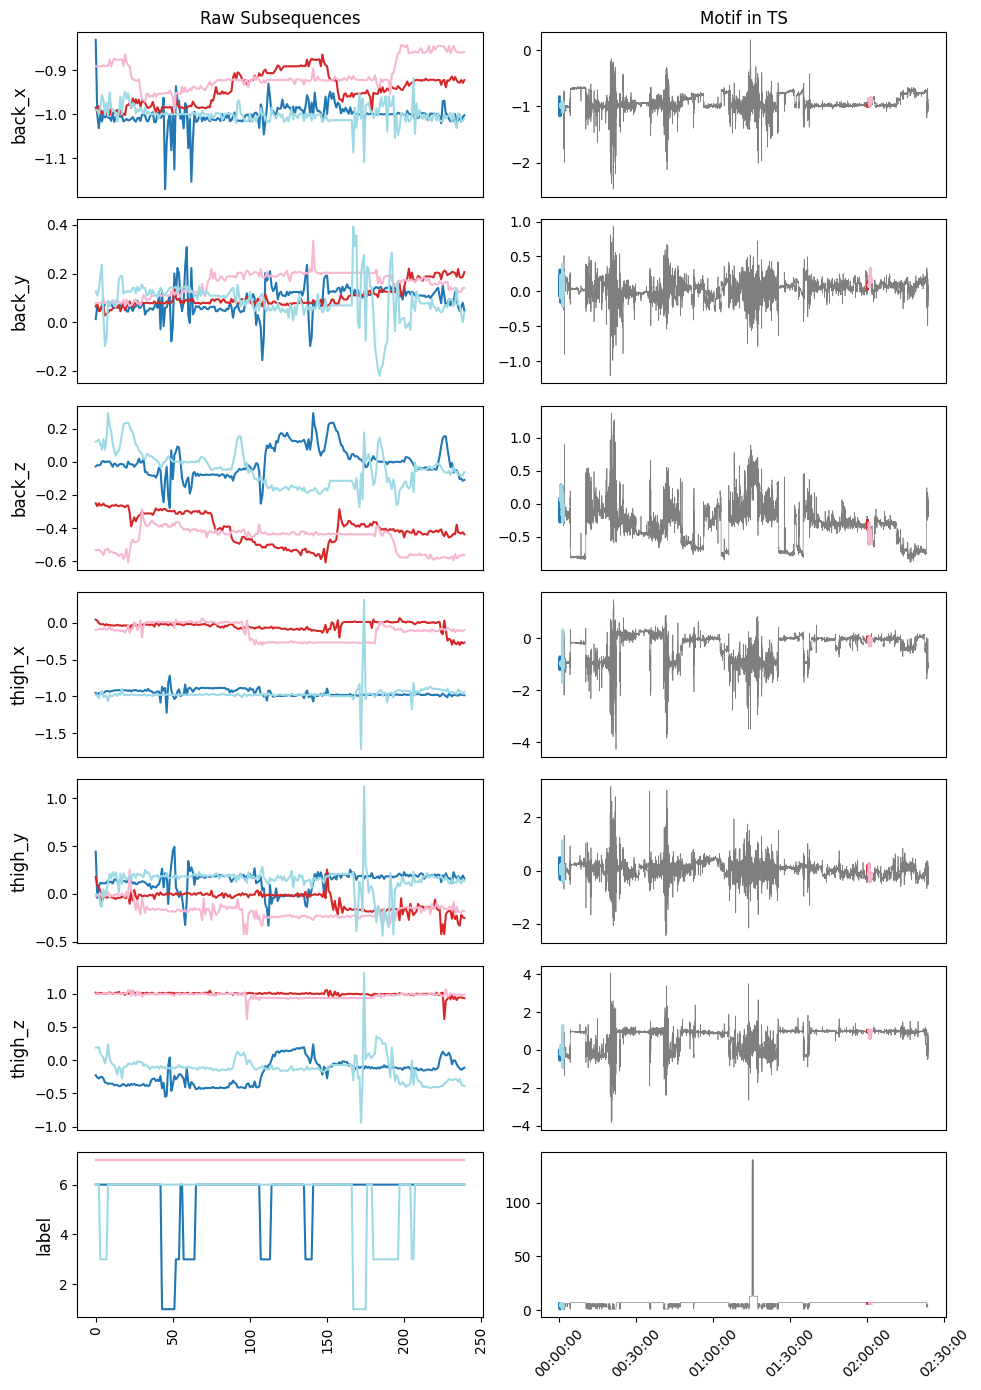

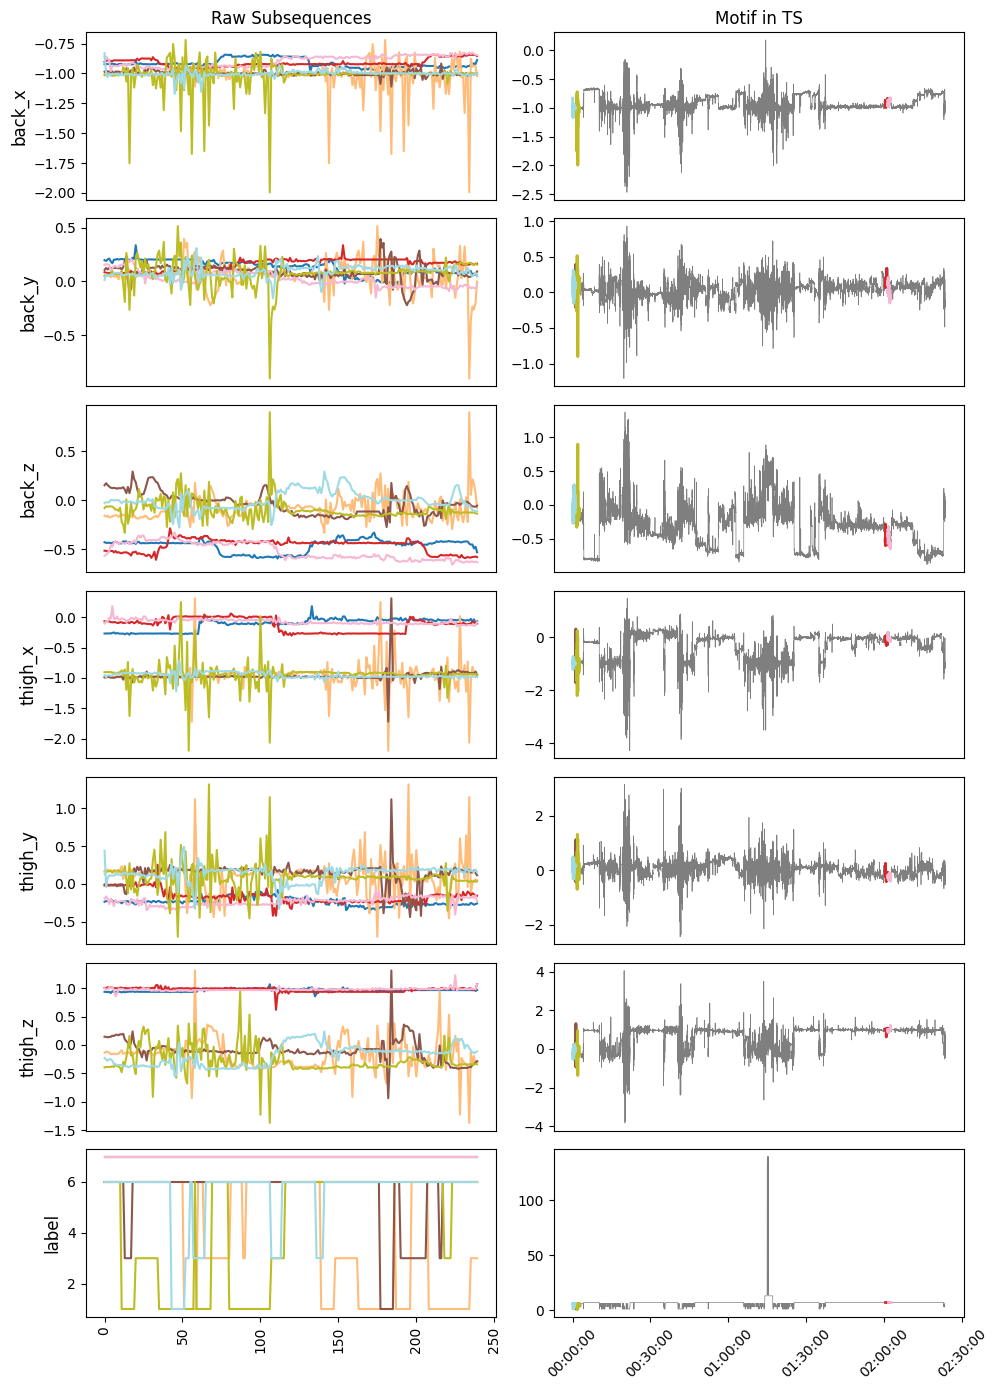

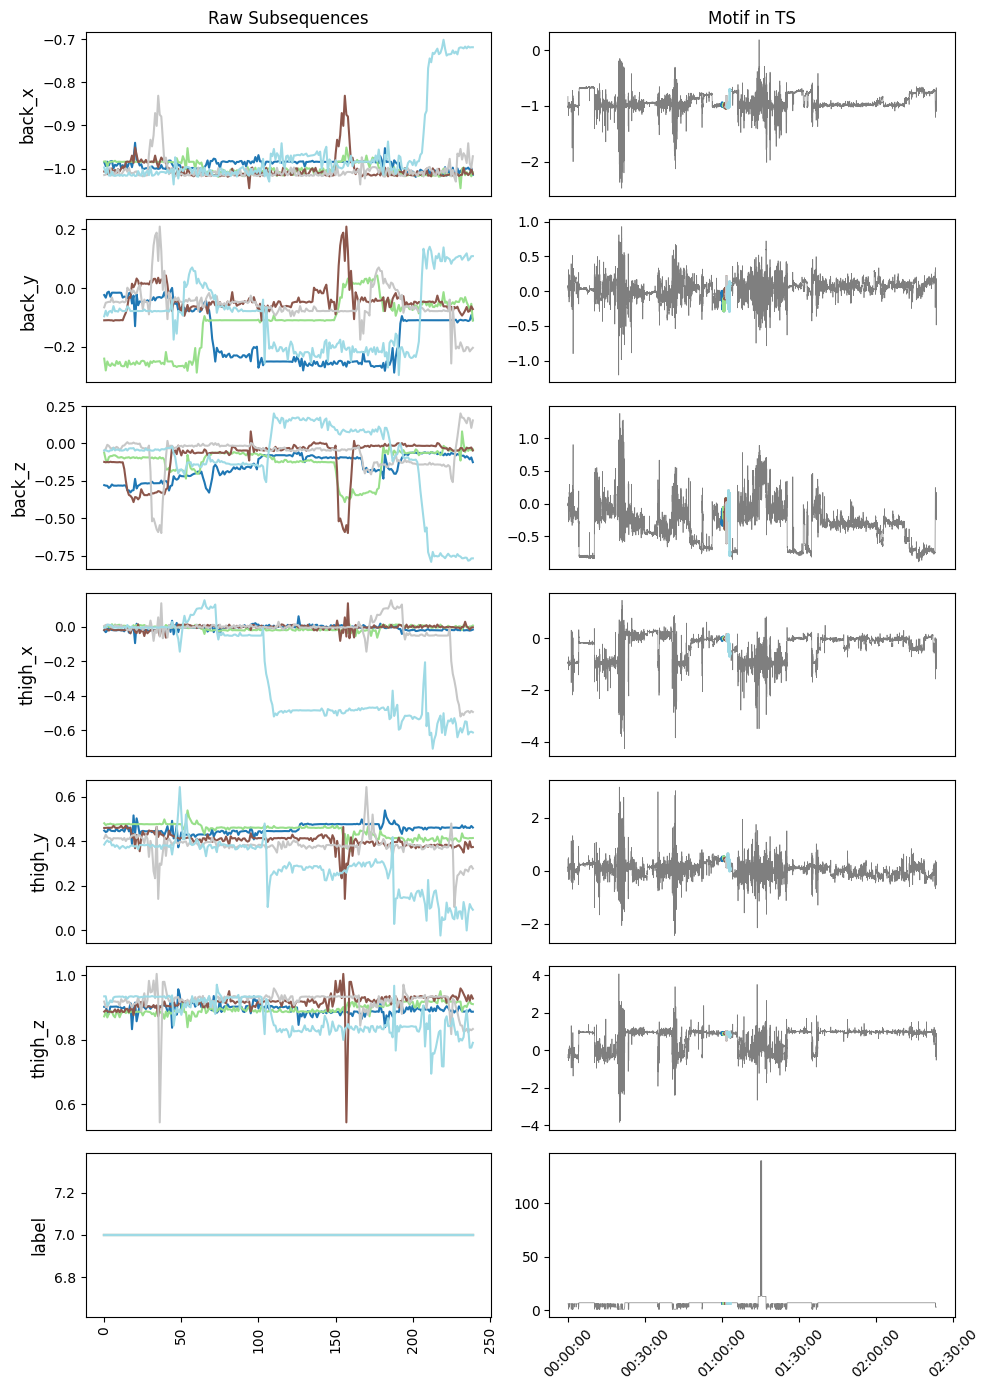

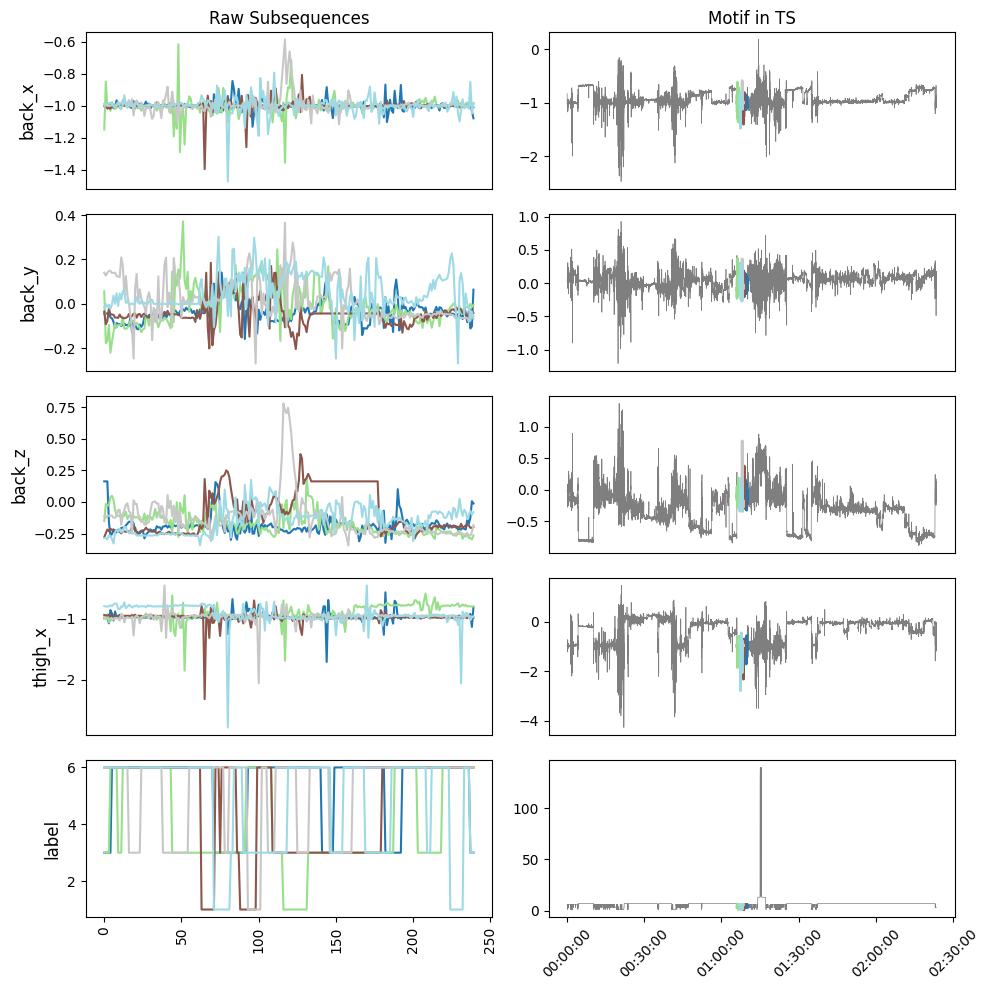

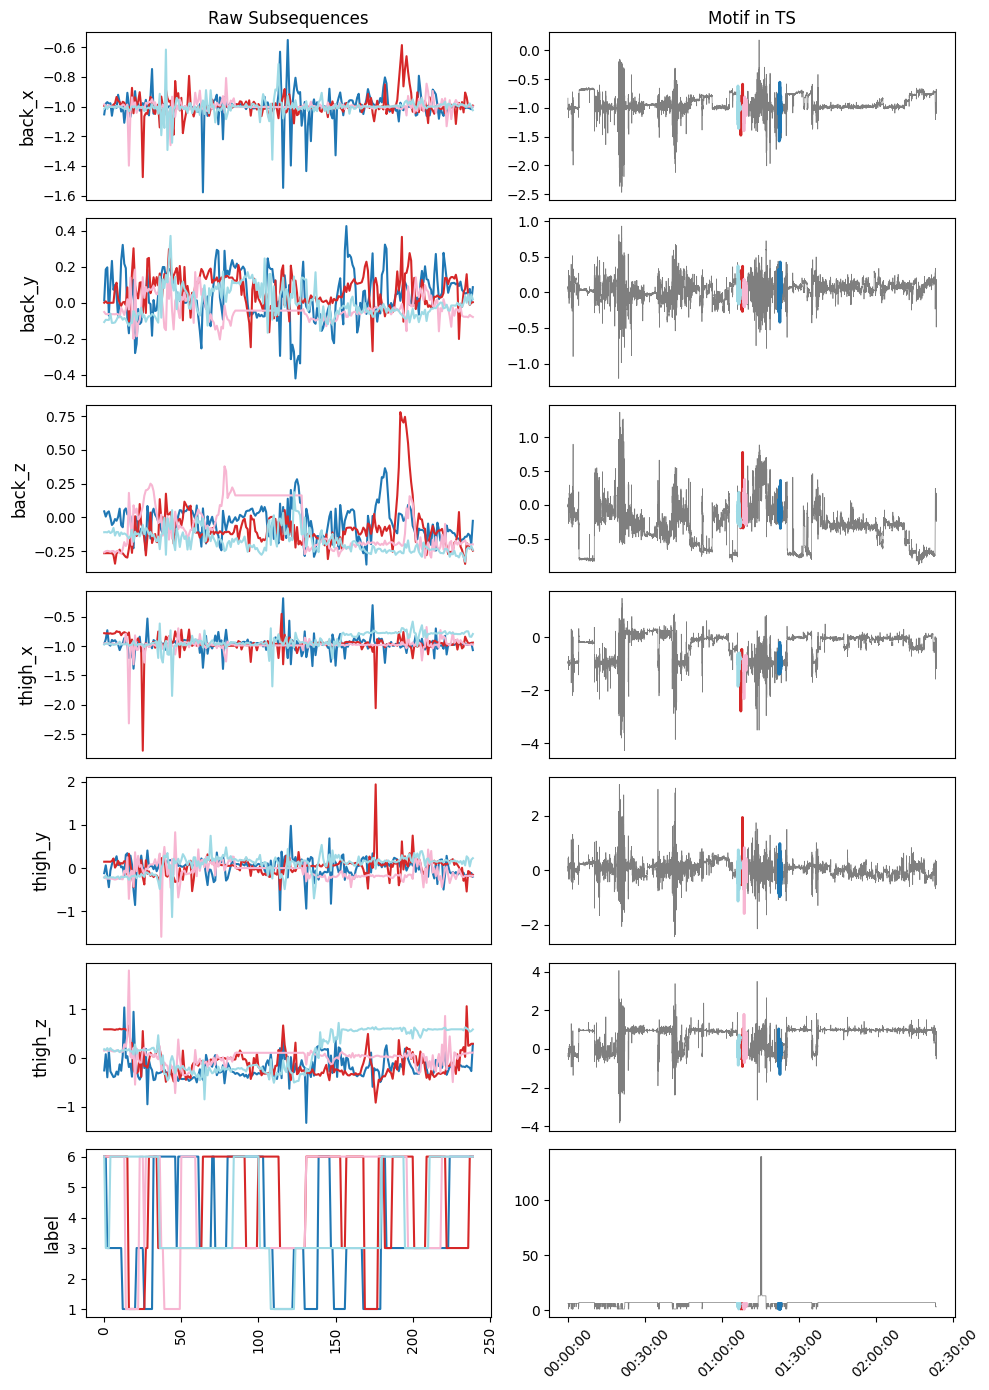

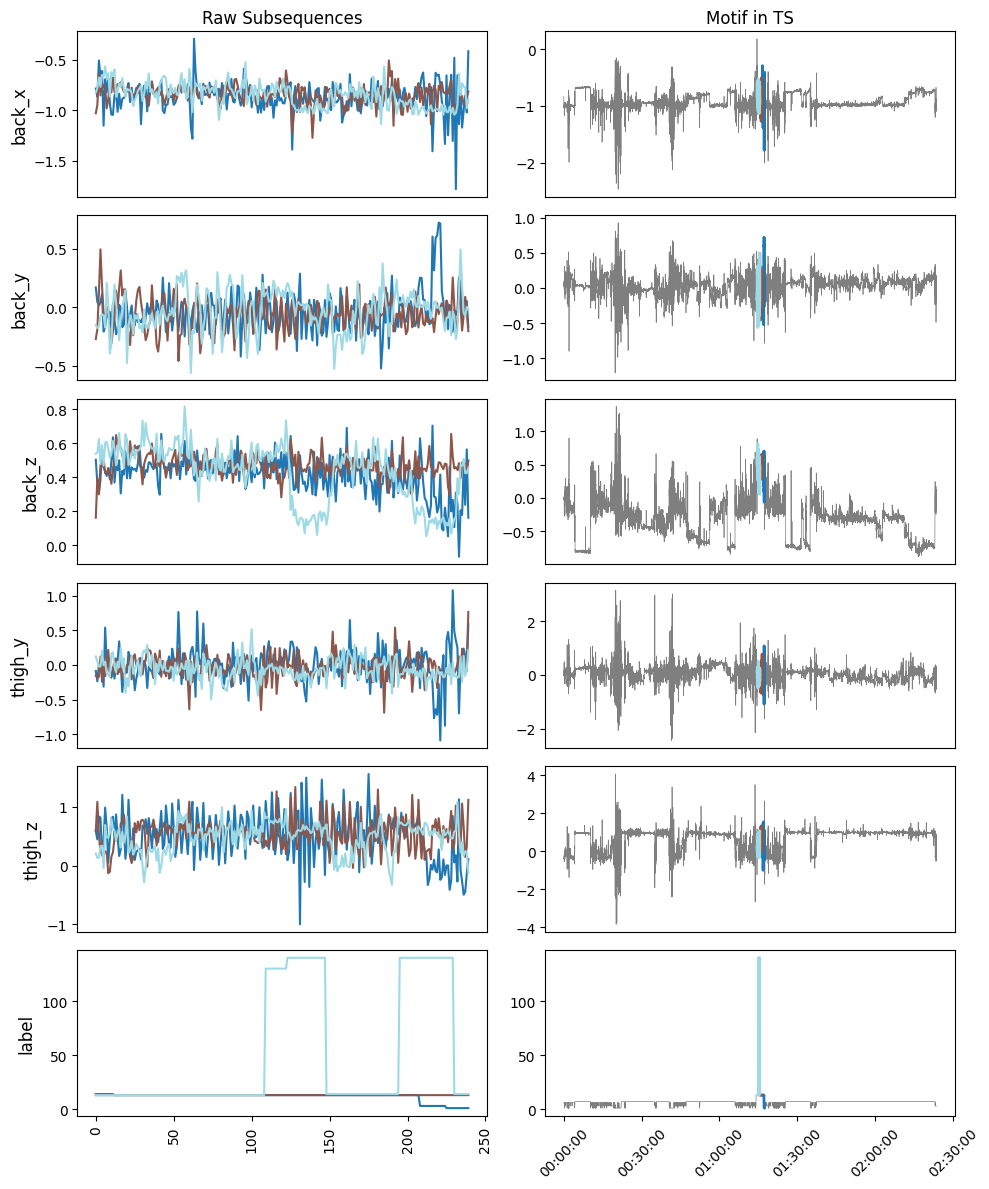

In [15]:
#plot top motif
mp_stats_table = pd.read_csv(results_path+'/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs))
subsequence_lengths = mp_stats_table["m"].unique()
ts = resids
for m in subsequence_lengths:
    print("Motif length: ", m)
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    for top_motif in top_motifs.to_dict(orient="records"): 
        m = top_motif["m"]
        dimensions = top_motif["Features"].split(",")
        dimensions = sorted([int(dimension) for dimension in dimensions])
        features = [data.columns[dimension] for dimension in dimensions]
        indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
        indices = [int(i) for i in indices]
        motif_name = top_motif["ID"]
        ts_list = [data[feature] for feature in features]
        ts_list.append(labels)
        features.append("label")
        plot_motif(ts_list, features, m, indices, motif_name)
